# Kalman Strategies

Trend-Following and Mean-reversion strategies on credit indices: Algorithmic  trading strategies using kalman filters

Diego Alvarez<br>
diego.alvarez@colorado.edu

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/CreditMomentum/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CreditMomentum\root\src")
from KalmanCDS import KalmanCreditDefaultSignals

## Background Signals Research

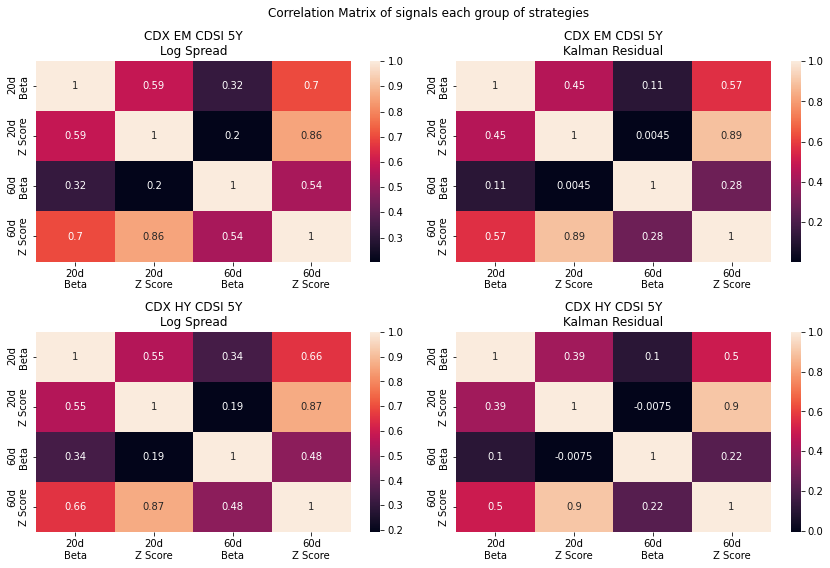

In [3]:
def plot_signal_correlation() -> plt.Figure: 

    df_tmp = (KalmanCreditDefaultSignals().backtest().assign(
        group_var  = lambda x: x.security + "\n" + np.where(x.input_var == "log_spread", "Log Spread", "Kalman Residual"),
        strat_name = lambda x: x.window.astype(str) + "d\n" + np.where(x.signal_group == "z_score", "Z Score", "Beta")))
    
    variables = df_tmp.group_var.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (12,8))
    
    
    for variable, ax in zip(variables, axes.flatten()):
    
        df_corr = (df_tmp.query(
            "group_var == @variable")
            [["date", "strat_name", "signal"]].
            drop_duplicates().
            pivot(index = "date", columns = "strat_name", values = "signal").
            corr())
    
        sns.heatmap(
            data =  df_corr,
            annot = True,
            ax    = ax)
    
        ax.set_title(variable)
        ax.set_xlabel("")
        ax.set_ylabel("")
    
    fig.suptitle("Correlation Matrix of signals each group of strategies")
    plt.tight_layout()

plot_signal_correlation()

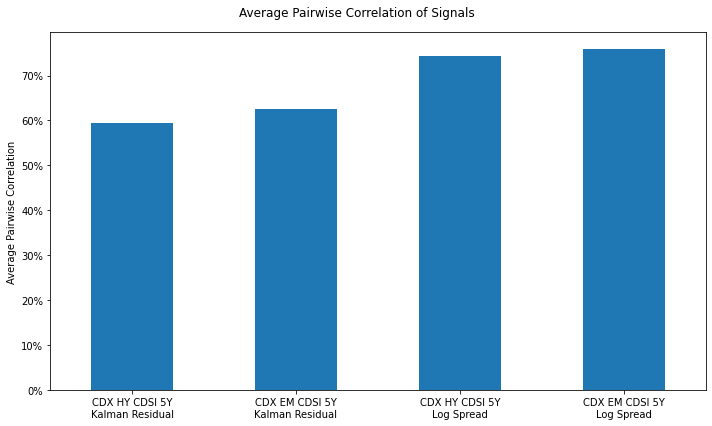

In [4]:
def _get_avg_cross_correlation(df: pd.DataFrame) -> pd.DataFrame: 

    df_corr = (df[
        ["date", "strat_name", "signal"]].
        drop_duplicates().
        pivot(index = "date", columns = "strat_name", values = "signal").
        corr())

    return np.tril(df_corr.unstack().values, -1).sum()

def get_avg_signal_cross_correlation() -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (10,6))
    
    (KalmanCreditDefaultSignals().backtest().assign(
        group_var  = lambda x: x.security + "\n" + np.where(x.input_var == "log_spread", "Log Spread", "Kalman Residual"),
        strat_name = lambda x: x.window.astype(str) + "d\n" + np.where(x.signal_group == "z_score", "Z Score", "Beta")).
        groupby("group_var").
        apply(_get_avg_cross_correlation).
        to_frame(name = "cross correlation").
        sort_values("cross correlation").
        plot(
            ax     = axes,
            kind   = "bar",
            legend = False,
            xlabel = "",
            ylabel = "Average Pairwise Correlation"))

    axes.tick_params(axis='x', labelrotation = 0)
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*1:.0f}%'))
    fig.suptitle("Average Pairwise Correlation of Signals")
    plt.tight_layout()
    
get_avg_signal_cross_correlation()

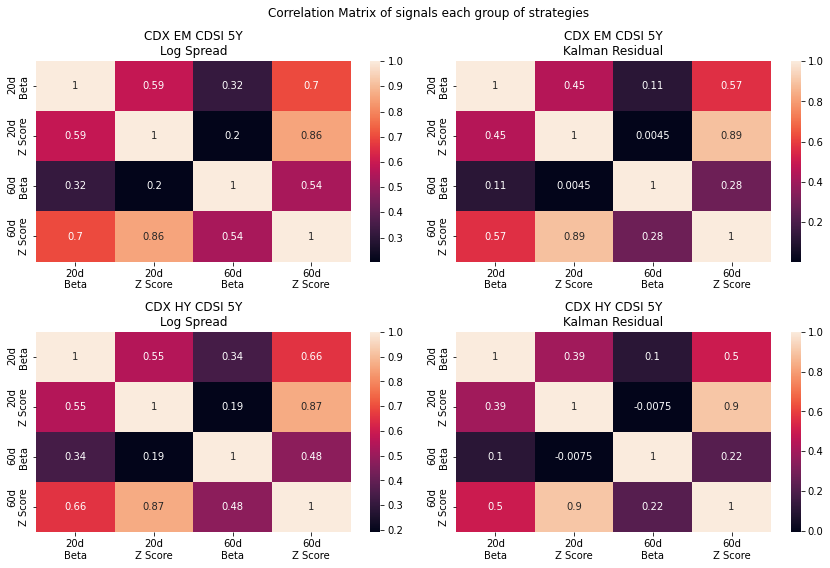

In [5]:
def plot_signal_rtn_corr() -> plt.Figure: 

    df_tmp = (KalmanCreditDefaultSignals().backtest().assign(
        group_var  = lambda x: x.security + "\n" + np.where(x.input_var == "log_spread", "Log Spread", "Kalman Residual"),
        strat_name = lambda x: x.window.astype(str) + "d\n" + np.where(x.signal_group == "z_score", "Z Score", "Beta")))
    
    variables = df_tmp.group_var.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (12,8))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        df_corr = (df_tmp.query(
            "group_var == @variable & rtn_type == 'px_rtn'")
            [["date", "strat_name", "signal_rtn"]].
            pivot(index = "date", columns = "strat_name", values = "signal_rtn").
            corr())
    
        sns.heatmap(
            data =  df_corr,
            annot = True,
            ax    = ax)
    
        ax.set_title(variable)
        ax.set_xlabel("")
        ax.set_ylabel("")
    
    fig.suptitle("Signal Returns Correlation")
    plt.tight_layout()

plot_signal_correlation()

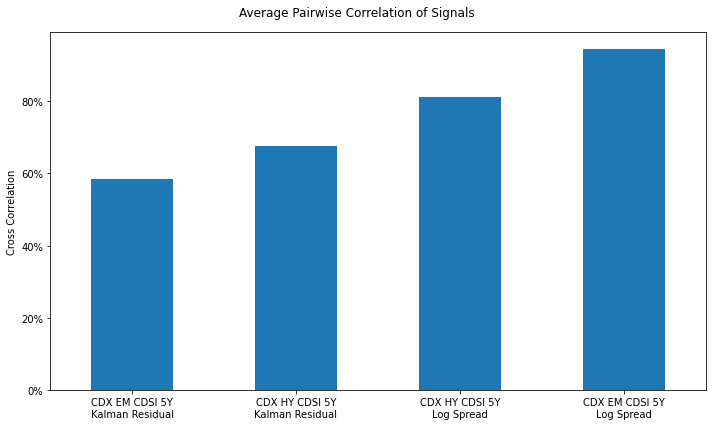

In [7]:
def _get_avg_rtn_cross_correlation(df: pd.DataFrame) -> pd.DataFrame: 

    df_corr = (df[
        ["date", "strat_name", "signal_rtn"]].
        drop_duplicates().
        pivot(index = "date", columns = "strat_name", values = "signal_rtn").
        corr())

    return np.tril(df_corr.unstack().values, -1).sum()

def plot_rtn_correlation() -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (10,6))
    (KalmanCreditDefaultSignals().backtest().assign(
        group_var  = lambda x: x.security + "\n" + np.where(x.input_var == "log_spread", "Log Spread", "Kalman Residual"),
        strat_name = lambda x: x.window.astype(str) + "d\n" + np.where(x.signal_group == "z_score", "Z Score", "Beta")).
        query("rtn_type == 'px_rtn'").
        groupby("group_var").
        apply(_get_avg_rtn_cross_correlation).
        to_frame(name = "Cross Correlation").
        sort_values("Cross Correlation").
        plot(
            ax     = axes,
            kind   = "bar",
            legend = False,
            ylabel = "Cross Correlation",
            xlabel = ""))
    
    axes.tick_params(axis='x', labelrotation = 0)
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*1:.0f}%'))
    fig.suptitle("Average Pairwise Correlation of Signals")
    plt.tight_layout()

plot_rtn_correlation()

## Backtested Returns

In [8]:
def get_rtn() -> pd.DataFrame: 
    
    df_tmp = (KalmanCreditDefaultSignals().backtest().assign(
        group_var  = lambda x: x.security + "\n" + np.where(x.input_var == "log_spread", "Log Spread", "Kalman Residual"),
        strat_name = lambda x: x.window.astype(str) + "d " + np.where(x.signal_group == "z_score", "Z Score", "Beta")).
        query("rtn_type == 'px_rtn'"))

    return df_tmp

df_rtn = get_rtn()

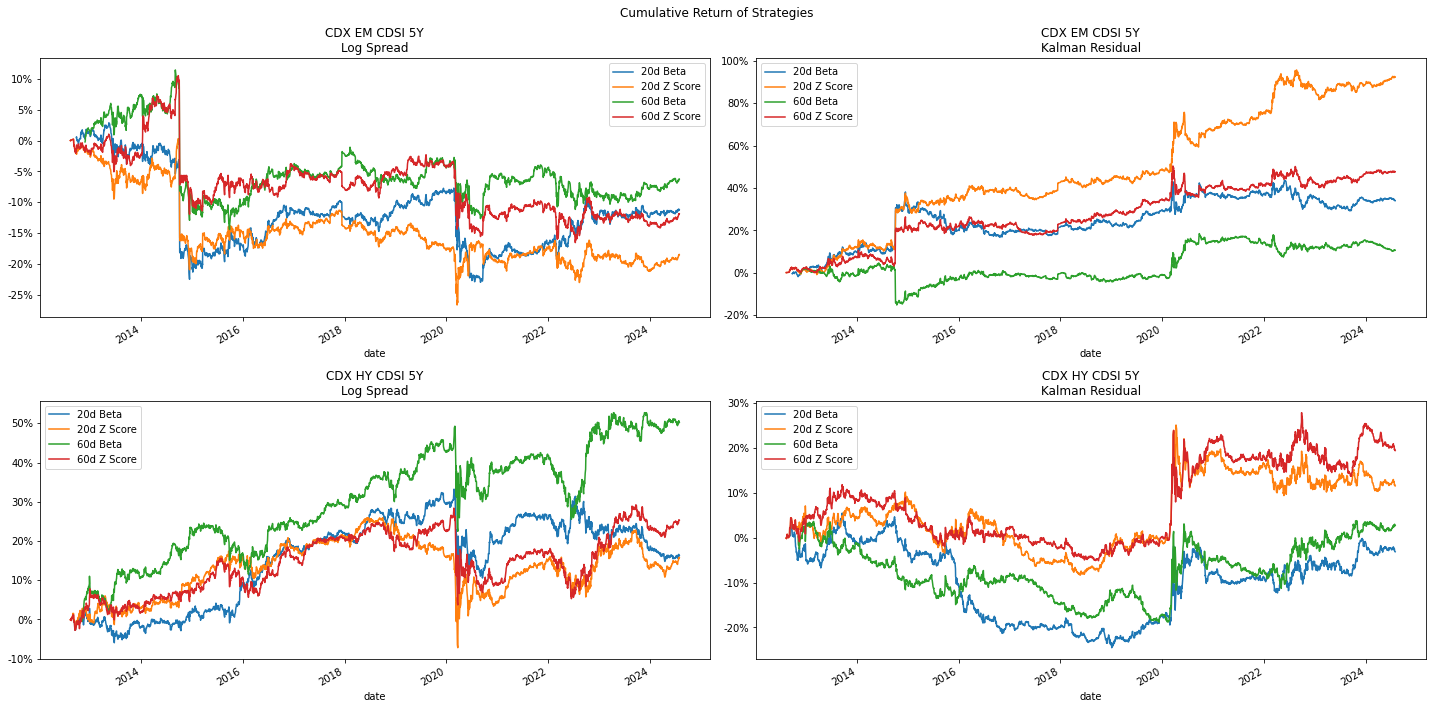

In [9]:
def plot_backtest(df_rtn: pd.DataFrame) -> plt.Figure: 
    
    variables = df_rtn.group_var.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 2, figsize = (20,10))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        (df_rtn.query(
            "group_var == @variable")
            [["date", "strat_name", "signal_rtn"]].
            rename(columns = {"strat_name": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax    = ax,
                title = variable))
    
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    
    fig.suptitle("Cumulative Return of Strategies")
    plt.tight_layout()

plot_backtest(df_rtn)

In [10]:
def get_sharpe(df_rtn: pd.DataFrame) -> pd.DataFrame: 

    df_sharpe = (df_rtn[
        ["signal_rtn", "group_var", "strat_name"]].
        groupby(["group_var", "strat_name"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std"}).
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index()
        [["group_var", "strat_name", "sharpe"]].
        assign(
            security     = lambda x: x.group_var.str.split("\n").str[0],
            signal_group = lambda x: x.group_var.str.split("\n").str[-1],
            strat        = lambda x: x.signal_group + "\n" + x.strat_name).
        drop(columns = ["group_var", "strat_name", "signal_group"]))
    
    df_raw = (df_rtn[
        ["date", "security", "rtn_val"]].
        drop_duplicates().
        drop(columns = ["date"]).
        groupby("security").
        agg(["mean", "std"])
        ["rtn_val"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std"}).
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(
            strat = "None",
            sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe", "strat"]].
        reset_index())
    
    df_out = pd.concat([df_sharpe, df_raw])
    return df_out

df_sharpe = get_sharpe(df_rtn)

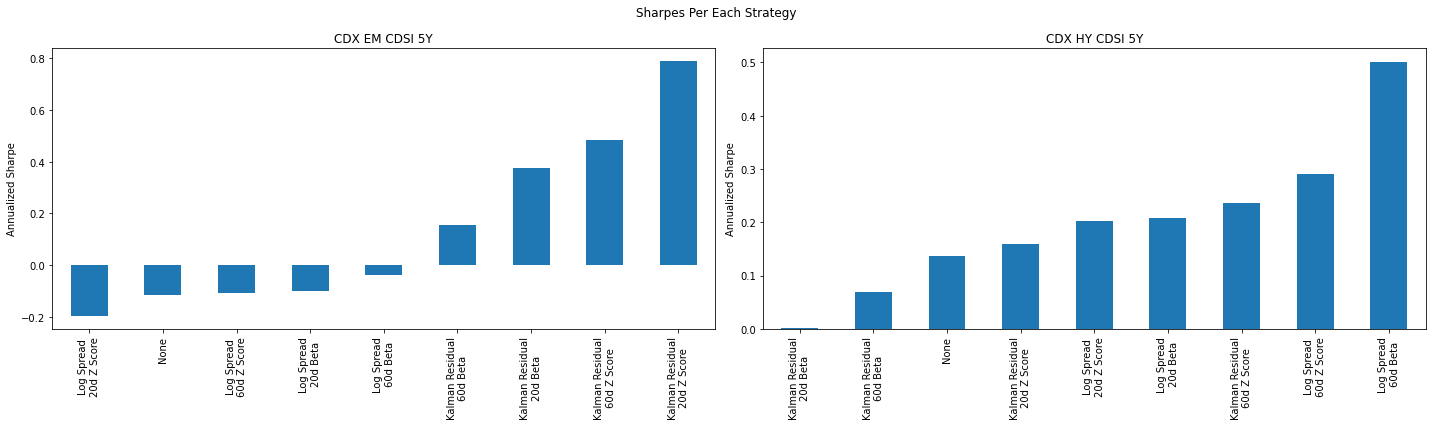

In [11]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 

    variables = df_sharpe.security.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        (df_sharpe.query(
            "security == @variable").
            set_index("strat")
            [["sharpe"]].
            sort_values("sharpe").
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                legend = False,
                title  = variable,
                ylabel = "Annualized Sharpe"))

    fig.suptitle("Sharpes Per Each Strategy")
    plt.tight_layout()

plot_sharpe(df_sharpe)

## Portfolio Optimization

In this case per each input indicator and model use a rolling maximize sharpe and then use equal risk contribution across those strategies 

In [12]:
def _get_rolling_sharpe(df: pd.DataFrame, window: int) -> pd.DataFrame:

    df_out = (df.sort_values(
        "date").
        assign(
            rolling_mean   = lambda x: x.signal_rtn.rolling(window = window).mean(),
            rolling_std    = lambda x: x.signal_rtn.rolling(window = window).std(),
            rolling_sharpe = lambda x: x.rolling_mean / x.rolling_std,
            lag_sharpe     = lambda x: x.rolling_sharpe.shift()).
        dropna().
        drop(columns = ["rolling_mean", "rolling_std", "rolling_sharpe"]))

    return df_out

def get_rolling_sharpe(df_rtn: pd.DataFrame, window: int = 20) -> pd.DataFrame: 

    df_rolling_sharpe = (df_rtn.rename(
        columns = {"group_var": "tmp"}).
        assign(group_var = lambda x: x.tmp + "+" + x.strat_name)
        [["date", "signal_rtn", "tmp", "strat_name", "group_var"]].
        groupby("group_var").
        apply(_get_rolling_sharpe, window).
        reset_index(drop = True).
        drop(columns = ["group_var"]))

    return df_rolling_sharpe

df_rolling_sharpe = get_rolling_sharpe(df_rtn)

In [13]:
def _get_max_sharpe(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.query(
        "lag_sharpe == lag_sharpe.max()").
        head(1))

    return df_out

def get_max_sharpe(df_rolling_sharpe: pd.DataFrame) -> pd.DataFrame:

    df_tmp = (df_rolling_sharpe.groupby(
        ["date", "tmp"]).
        apply(_get_max_sharpe).
        reset_index(drop = True))

    return df_tmp

df_max_sharpe = get_max_sharpe(df_rolling_sharpe)

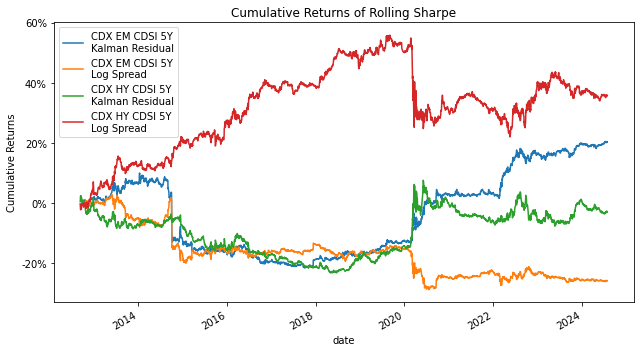

In [14]:
def plot_cumulative_max_sharpe(df_max_sharpe: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (9,5))
    
    (df_max_sharpe[
        ["date", "signal_rtn", "tmp"]].
        rename(columns = {"tmp": ""}).
        pivot(index = "date", columns = "", values = "signal_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes,
            ylabel = "Cumulative Returns",
            title  = "Cumulative Returns of Rolling Sharpe"))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    plt.tight_layout()

plot_cumulative_max_sharpe(df_max_sharpe)

In [15]:
def _get_vol(df: pd.DataFrame, window: int) -> pd.DataFrame:

    df_out = (df.sort_values(
        "date").
        assign(
            roll_vol = lambda x: x.signal_rtn.ewm(span = window, adjust = False).std(),
            lag_vol  = lambda x: x.roll_vol.shift(),
            inv_vol  = lambda x: 1 / x.lag_vol).
        dropna())

    return df_out

In [16]:
def get_erc(df_max_sharpe: pd.DataFrame, window: int = 30) -> pd.DataFrame:
      
    df_vol = (df_max_sharpe.drop(
        columns = ["strat_name", "lag_sharpe"]).
        groupby("tmp").
        apply(_get_vol, window).
        reset_index(drop = True).
        dropna())
    
    df_erc = (df_vol[
        ["date", "inv_vol"]].
        groupby("date").
        agg("sum").
        rename(columns = {"inv_vol": "cum_vol"}).
        merge(right = df_vol, how = "inner", on = ["date"]).
        assign(weight_rtn = lambda x: x.inv_vol / x.cum_vol * x.signal_rtn)
        [["date", "weight_rtn"]].
        groupby("date").
        agg("sum"))

    return df_erc

df_erc = get_erc(df_max_sharpe)

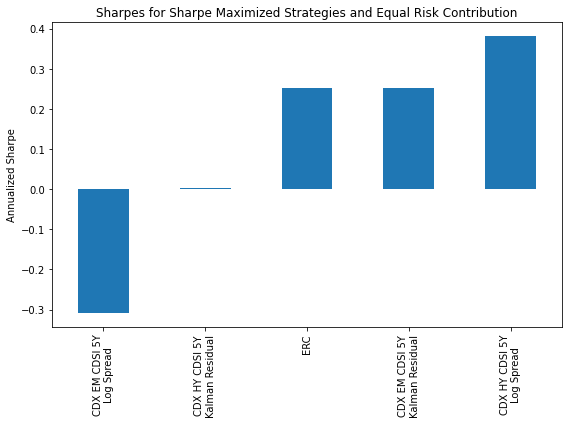

In [17]:
def plot_strat_sharpe(df_erc: pd.DataFrame, df_max_sharpe: pd.DataFrame) -> plt.Figure: 

    df_tmp = (df_erc.reset_index().rename(
        columns = {"weight_rtn": "signal_rtn"}).
        assign(tmp = "ERC"))
    
    df_sharpe_tmp = (df_max_sharpe[
        ["date", "signal_rtn", "tmp"]])
    
    (pd.concat([
        df_tmp, df_sharpe_tmp]).
        drop(columns = ["date"]).
        groupby("tmp").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        sort_values("sharpe").
        plot(
            ylabel  = "Annualized Sharpe",
            figsize = (8,6),
            kind    = "bar",
            legend  = False,
            xlabel  = "",
            title   = "Sharpes for Sharpe Maximized Strategies and Equal Risk Contribution"))
    
    plt.tight_layout()

plot_strat_sharpe(df_erc, df_max_sharpe)